In [104]:
from google.colab import drive
import os
import pandas as pd

In [106]:
current_directory = "/data"
os.chdir(current_directory)

In [ ]:
!pip install ntlk
!pip install num2words
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install textblob

In [110]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize, pos_tag, ne_chunk
from nltk import RegexpParser
from nltk import Tree

import textblob
from textblob import TextBlob
import re
import num2words
import json
from fuzzywuzzy import utils

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('maxent_ne_chunker')
nltk.download('words')

Intialise Classes for Product Review Identification and Segmentation

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install deepmultilingualpunctuation
from deepmultilingualpunctuation import PunctuationModel

In [ ]:
#For segmentation of transcript into product reviews
!pip install ruptures
!pip install sentence_transformers
import ruptures as rpt
from ruptures.base import BaseCost
from sentence_transformers import SentenceTransformer, util

In [8]:
import math

class ProductIdentifier:
  def __init__(self):
    pass

  def remove_non_ascii(self, text):
    return re.sub(r'[^\x00-\x7F]+',' ', text)

  def GetNounsWithNLTK(self, text, chunk_func=ne_chunk):
    chunked = chunk_func(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
      if type(subtree) == Tree:
        current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
      elif current_chunk:
        named_entity = " ".join(current_chunk)
        if named_entity not in continuous_chunk:
          continuous_chunk.append(named_entity)
          current_chunk = []
      else:
        continue

    return continuous_chunk

  def get_uppercased_word_series(self, text):
    temp_lst = []
    uppercased_word_lst = []
    word_lst = nltk.word_tokenize(text)
    for i in range(len(word_lst)):
      word = word_lst[i]
      starts_with_uppercase = word[0].isupper()
      if starts_with_uppercase:
        temp_lst.append(word)
        if (i == len(word_lst)-1):
          if len(temp_lst) >= 2:
            uppercased_word_lst.append(" ".join(temp_lst))
        continue
      else:
        if len(temp_lst) >= 2:
          uppercased_word_lst.append(" ".join(temp_lst))
        temp_lst = []
    return list(set(uppercased_word_lst))

  def Check_If_NP_Is_Known_Product(self,np, product_lexicon):
    for product in product_lexicon:
      if np == product:
        return True
    return False

  def Check_If_NP_Has_Product_Indicator(self, np, product_indicators):
    for product in product_indicators:
      similarity = fuzz.partial_ratio(np.lower(),product.lower())
      if similarity >= 80:
        return True
    return False

  def Check_If_NP_Is_Product(self, np, product_indicators, product_lexicon):
    if self.Check_If_NP_Is_Known_Product(np, product_lexicon):
      return True
    elif self.Check_If_NP_Has_Product_Indicator(np, product_indicators):
      return True
    else:
      return False

  def is_not_substring_of_another_product(self,product, product_lst):
    for comparison_product in product_lst:
      if product.lower() == comparison_product.lower():
        continue
      if product.lower() in comparison_product.lower():
        return False
    return True

  def detect_products_from_transcript(self, text, product_indicators, product_lexicon):
    #sometimes nltk ne chunker misses out
    nouns_in_transcript = self.GetNounsWithNLTK(text)
    #parse for a series of uppercase
    uppercased_series_lst = self.get_uppercased_word_series(text)

    #nouns_in_transcript.extend(np_lst)
    nouns_in_transcript.extend(uppercased_series_lst)

    #only keep if len > 2 
    nouns_in_transcript = list(filter(lambda noun_phrase: len(nltk.word_tokenize(noun_phrase))>=2, nouns_in_transcript))

    #keep if match with brand name or contain a product term
    nouns_in_transcript = list(filter(lambda noun_phrase: self.Check_If_NP_Is_Product(noun_phrase, product_indicators, product_lexicon), nouns_in_transcript))

    #filter the products
    nouns_in_transcript = list(filter(lambda product: self.is_not_substring_of_another_product(product, nouns_in_transcript), nouns_in_transcript))

    return list(set(nouns_in_transcript))


  def contains_url(self,text):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex, text)
    if url != []:
      return True
    else:
      return False

  def remove_url(self,text):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    removed_url_text = re.sub(regex, "", text)
    return removed_url_text

  def clean_desc(self,text):
    text = text.replace(":", "")
    text = text.replace("*", "")
    text = self.remove_non_ascii(text)
    text = self.remove_url(text)
    text = re.sub(r'#\S+', '', text)
    text = text.replace("https","")
    return text.strip()

  def GetNounPhrasesWithSyntaxRules(self, text):
    nounphrases = []
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    chunk_name_lst = ["NP"]
    grammar = r"""  NP:
              {<NN|NNS|NNP|NNPS>+}
          """
    chunkParser=nltk.RegexpParser(grammar)
    tree = chunkParser.parse(tagged)
    for subtree in tree.subtrees(filter=lambda t: t.label() in chunk_name_lst):
        myPhrase = ''
        for item in subtree.leaves():
            myPhrase += ' ' + item[0]
        nounphrases.append(myPhrase.strip())
    nounphrases = list(filter(lambda x: len(x.split()) > 1, nounphrases))
    return nounphrases
  
  def GetNPWithSyntaxRules(self, text):
    nounphrases = []
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    chunk_name_lst = ["NP","Product"]
    grammar = r"""  NP:
              {<NN|NNS|NNP|NNPS>+}
              Product:
              {<NN.*|NNS.*|NNP.*|NNPS.*><NN|VBZ|JJ|JJS|JJR|NNS|NNP|NNPS|VBD|CD|RB>+}
          """
    chunkParser=nltk.RegexpParser(grammar)
    tree = chunkParser.parse(tagged)
    for subtree in tree.subtrees(filter=lambda t: t.label() in chunk_name_lst):
        myPhrase = ''
        for item in subtree.leaves():
            myPhrase += ' ' + item[0]
        nounphrases.append(myPhrase.strip())
    nounphrases = list(filter(lambda x: len(x.split()) > 1, nounphrases))
    return nounphrases

  def get_products_from_desc(self,description):
    if description == None:
      return []
    split_desc = description.split("\n")
    #set higher threshold because even if e.g. "mal" "ibu" match seperately -- it raises the match score
    products = []
    for sent in split_desc:
      if sent != "":
        products.extend(self.GetNPWithSyntaxRules(sent))
    products = [self.clean_desc(txt) for txt in products]
    products = list(filter(lambda txt: self.Check_If_NP_Is_Product(txt, product_indicators, product_lexicon),products))
    products = list(filter(lambda txt: self.is_not_substring_of_another_product(txt,products),products))
    return products
  
  def detect_products(self,text,description,product_indicators, product_lexicon):
    #filtered_transcript_product_lst = self.detect_products_from_transcript(text, product_indicators, product_lexicon)
    filtered_transcript_product_lst = self.get_products_from_desc(description)
    #filtered_transcript_product_lst.extend(filtered_desc_product_lst)
    filtered_product_lst = list(filter(lambda txt: self.is_not_substring_of_another_product(txt,filtered_transcript_product_lst),filtered_transcript_product_lst))
    filtered_product_lst = list(set(filtered_product_lst))
    return filtered_product_lst

class CoreferenceResolver:
  def __init__(self):
    self.product_identifier = ProductIdentifier()
  
  def GetCoreferenceWithSyntaxRules(self,text):
    coref = []
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    chunk_name_lst = ["DT","DT Ref"]
    grammar = r"""
              DT Ref:
              {<DT><CD>}
          """
    chunkParser=nltk.RegexpParser(grammar)
    tree = chunkParser.parse(tagged)
    for subtree in tree.subtrees(filter=lambda t: t.label() in chunk_name_lst):
      myPhrase = ''
      for item in subtree.leaves():
        myPhrase += ' ' + item[0]
      coref.append(myPhrase.strip())
    coref = list(filter(lambda x: len(x.split()) > 1, coref))
    filtered_coref = list(set(coref))
    return filtered_coref

  def replace_all(self, text, dic):
    for i, j in dic.items():
        text = re.sub(r"\b%s\b" % i, j, text)
        # r"\b%s\b"% enables replacing by whole word matches only
    return text

  def detect_matching_product_name(self, sentence, product_lst,product_indicators, product_lexicon):
    np_lst = self.product_identifier.GetNPWithSyntaxRules(sentence)
    for np in np_lst:
      for product in product_lst:
        similarity_with_identified_products = fuzz.partial_ratio(np.lower(),product.lower())
        if similarity_with_identified_products >= 80 or np in product:
          return (np,product)
    for np in np_lst:
      if self.product_identifier.Check_If_NP_Is_Product(np, product_indicators, product_lexicon):
        return (np,np)
    return None


  def resolve(self, sample_sentences, product_lst, product_indicators, product_lexicon):
    curr_product_name = None
    resolved_combined_sentence_list = []
    for sentence in sample_sentences:
      #update current product name
      potentially_new_product_name_pair = self.detect_matching_product_name(sentence, product_lst,product_indicators, product_lexicon)
      if potentially_new_product_name_pair != None and potentially_new_product_name_pair != curr_product_name:
        #must identify the product name better
        phrase = potentially_new_product_name_pair[0]
        curr_product_name = potentially_new_product_name_pair[1]
        #pos_tag sentence --> assign determiners after the product name to the product name
        substr_before_product = sentence.split(phrase,1)[0] + curr_product_name
        substr_after_product = sentence.split(phrase,1)[-1]
        replacements = {'This':curr_product_name,'this':curr_product_name,'it':curr_product_name, 'It':curr_product_name}
        substr_after_product = self.replace_all(substr_after_product, replacements)
        resolved_combined_sentence_list.append(substr_before_product + substr_after_product)
      
      elif curr_product_name != None:
        #replace all references with the curr_product_name
        replacements = {'This':curr_product_name,'this':curr_product_name,'it':curr_product_name, 'It':curr_product_name}
        sentence = self.replace_all(sentence, replacements)
        resolved_combined_sentence_list.append(sentence)
      
      else:
        resolved_combined_sentence_list.append(sentence)
    
    return resolved_combined_sentence_list

  def resolve_sentences(self,sample_sentences, product_lst,product_indicators, product_lexicon):
    sample_sentences = [sentence.replace("\n", " ") for sentence in sample_sentences]
    resolved_list = self.resolve(sample_sentences, product_lst,product_indicators, product_lexicon)
    return resolved_list

#Define cost function for segmentation
class CosineCost(BaseCost):
    """Cost derived from the cosine similarity."""

    # The 2 following attributes must be specified for compatibility.
    model = "custom_cosine"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        self.gram = util.cos_sim(signal, signal)
        return self

    def error(self, start, end) -> float:
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment
        Returns:
            segment cost
        Raises:
            NotEnoughPoints: when the segment is too short (less than `min_size` samples).
        """
        if end - start < self.min_size:
            raise NotEnoughPoints
        sub_gram = self.gram[start:end, start:end]
        val = sub_gram.diagonal().sum()
        val -= sub_gram.sum() / (end - start)
        return val

class TranscriptSegmenter:
  def __init__(self):
    self.product_identifier = ProductIdentifier()
    self.coreference_resolver = CoreferenceResolver()
    self.punctuator = PunctuationModel()
    self.segmentation_cost_function_class = CosineCost()
    self.sentence_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

  def further_split_sentence(self, nltk_sent_tokenized_list):
    #use punctuator to improve splitting
    final_sent_lst = []
    for sent in nltk_sent_tokenized_list:
      punctuated_sent = self.punctuator.restore_punctuation(sent)
      split_sent = punctuated_sent.split(".")
      final_sent_lst.extend(split_sent)
    return final_sent_lst

  def get_sentence_list_from_transcript(self, transcript):
    transcript = self.product_identifier.remove_non_ascii(transcript)
    phrases = self.further_split_sentence(nltk.sent_tokenize(transcript))
    if len(phrases) == 0:
      return []
    phrases = list(filter(lambda phrase: phrase != "", phrases))
    pos_tagged = [pos_tag(nltk.word_tokenize(sentence.lower())) for sentence in phrases]
    new_combined_sentence_list = [""]
    for i in range(len(phrases)):
      tagged_phrase = pos_tagged[i]
      tag_of_first_word = tagged_phrase[0][1]
      conjunctions_lst = ["IN", "CC", "WDT", "TO", "WRB", "VBG", "VBZ", "RB"]
      end_lst = ["IN", "CC", "WDT", "TO", "WRB", "VBG", "VBZ", "DT", "RB"]
      join_sentence = False
      if i >= 1:
        last_tag_in_prev_sentence = pos_tagged[i-1][-1][1]
        if last_tag_in_prev_sentence in end_lst:
          join_sentence = True
      if tag_of_first_word in conjunctions_lst:
        join_sentence = True

      if join_sentence:
        #lowercase the first letter to reduce noise when doing NP identification e.g. "Which is so beautiful" --> Which to which
        sub_clause = phrases[i].replace(phrases[i][0],phrases[i][0].lower(),1)
        new_combined_sentence_list[-1] = new_combined_sentence_list[-1] + " " + sub_clause
      else:
        new_combined_sentence_list.append(phrases[i])
    return new_combined_sentence_list

  def segment_transcript_ruptures(self, filtered_product_lst, resolved_sentences, original_sentences, product_indicators, product_lexicon):
    #Find breaks where similarity between chunks is the lowest
    num_products = len(filtered_product_lst)
    embeddings = self.sentence_embedding_model.encode(resolved_sentences, convert_to_tensor=True)
    n_bkps = num_products-1+2  # e.g. there are 9 change points (10 text segments) + intro and outrp
    min_size = 2
    jump = 1
    #to create valid segmentation paramters
    if n_bkps > len(embeddings) or n_bkps * math.ceil(min_size/ jump) * jump + min_size > len(embeddings): 
      n_bkps = round(math.ceil(min_size/ jump) * jump + min_size)
    algo = rpt.Dynp(custom_cost=self.segmentation_cost_function_class, min_size=min_size, jump=jump).fit(embeddings)
    predicted_bkps = algo.predict(n_bkps=n_bkps)
    iteration_lst = predicted_bkps
    iteration_lst.insert(0, 0)

    chunk_lst = []
    product_review_dict = {}
    for i in range(len(iteration_lst)-1):
      chunk_resolved = " ".join(resolved_sentences[iteration_lst[i]:iteration_lst[i+1]])
      chunk_org = " ".join(original_sentences[iteration_lst[i]:iteration_lst[i+1]])
      product = self.coreference_resolver.detect_matching_product_name(chunk_resolved, filtered_product_lst,product_indicators, product_lexicon)
      if product != None:
        product_review_dict[product[1]] = {"original":chunk_org}
    return product_review_dict

  def segment_transcript(self, filtered_product_lst, resolved_list, new_combined_sentence_list):
    product_review_dict = {}
    for i in range(len(resolved_list)):
      resolved_sentence = resolved_list[i]
      for product in filtered_product_lst:
        if product in resolved_sentence:
          if product in product_review_dict:
            #product_review_dict[product]["resolved"] = product_review_dict[product]["resolved"] + resolved_sentence
            product_review_dict[product]["original"] = product_review_dict[product]["original"] + new_combined_sentence_list[i]
          else:
            product_review_dict[product] = {"original":new_combined_sentence_list[i]}
    
    return product_review_dict

  def split_transcript_by_detected_products(self, review_dict, product_indicators, product_lexicon):
    transcript = review_dict["transcript_text"]
    description = review_dict["description"]
    filtered_product_lst = self.product_identifier.detect_products(transcript, description, product_indicators, product_lexicon)
    sample_sentences = self.get_sentence_list_from_transcript(transcript)
    resolved_lst = self.coreference_resolver.resolve_sentences(sample_sentences, filtered_product_lst,product_indicators, product_lexicon)
    #product_review_dict = self.segment_transcript(filtered_product_lst, resolved_lst, sample_sentences)
    product_review_dict = self.segment_transcript_ruptures(filtered_product_lst, resolved_lst, sample_sentences, product_indicators, product_lexicon)
    return product_review_dict

  #Case of video having chapters

  def process_raw_transcript(self, raw_transcript):
    text_list = [segment["text"] for segment in raw_transcript]
    text = " ".join(text_list)
    text = re.sub("\n", " ", text)
    #remove non-ascii characters -- to remove foreign lang characters
    text = self.product_identifier.remove_non_ascii(text)
    return text

  def split_transcript_by_chapters(self, raw_transcript, chapters):
    starts = [round(segment["start"]) for segment in raw_transcript]
    product_review_dict = {}
    chapter_index_list = []
    for chapter in chapters:
      time_in_sec = round(chapter["time_in_min"] * 60)
      #get a index list of chapters 
      new_insertion_index = bisect.bisect_left(starts, time_in_sec)
      chapter_index_list.append(new_insertion_index)
    chapter_index_list.append(len(raw_transcript)-1)
    for i in range(len(chapter_index_list)-1):
      title = chapters[i]["title"]
      start_index = chapter_index_list[i]
      end_index = chapter_index_list[i+1]
      original_raw_transcript = self.process_raw_transcript(raw_transcript[start_index:end_index])
      sample_sentences = [segment["text"] for segment in raw_transcript[start_index:end_index]]
      #resolved_raw_transcript = self.coreference_resolver.resolve_sentences(sample_sentences, [title])
      product_review_dict[title] = {"original":original_raw_transcript}
    return product_review_dict


  def get_product_review_dict(self, review_dict, product_indicator, product_lexicon):
    chapters = sample_review_dict["chapters"]
    product_review_dict = {}
    if chapters == []:
      product_review_dict = self.split_transcript_by_detected_products(review_dict, product_indicator, product_lexicon)
    else:
      raw_transcript = sample_review_dict["transcript_raw"]
      product_review_dict = self.split_transcript_by_chapters(raw_transcript, chapters)
    return product_review_dict


Load a sample review from Youtube Data for experimentation

In [9]:
import bisect
import json
from fuzzywuzzy import fuzz

In [10]:
#Load data scraped using various Youtube API
with open('DemoData.json', 'r') as f:
  reviews = json.load(f)

In [11]:
video_id_lst = [video_id for video_id, review in reviews.items()]
key = video_id_lst[0]
sample_review_dict = reviews[key]
sample_review_dict

{'UKISS Volume Booster Lash Primer Mascara': {'original': 'It is cheap and easy to use\n, this pink one from UKISS Eyelash primer\nIt is a\nfan-shaped brush and it is\nalso black. after you apply it, it feels like a\nvery light mascara,\nbut it can keep your curls lasting all day long, and it\nwill not faint or fall off.I feel It is\nbetter\nthan the Aidu yarn I used before.It\nmakes your eyelashes distinct.I\ncan feel at ease when I go\nout with it, especially when\n \nI go out to play.'},
 'Make Up For Ever MATTE VELVET SKIN COMPACT Y225': {'original': 'forever Changed make up for ever\nMatte Velvet Skin\nthis me I have used\nmany boxes, and the\niron sheet is the best proof.I can t think of a second\nblemish eraser\n. once you apply it on all your blemish lines, the\nspots will disappear.The\nonly and only flaw\nI can find out about this powder\nis that its oil control power is not very high\n. so I recommend that you use the sandwich method,\nloose powder and then loose powder\n, s

In [12]:
sample_review = sample_review_dict['NYX SLIM EYE PENCIL - Dark Brown']["original"]
sample_review

'Let me\nfirst say that if\n \nyour eyes are prone to dizziness like inner double eyeliner, it\nmay not be suitable for it\n, but if you just have a very daily\nwork makeup and you don t want to look abrupt, if you\nwant to draw a very natural brown eyeliner,\nit is very suitable for\nNYX The eye pencil\nis a very traditional eyeliner.It is cut off\nwith a pencil sharpener. basically, you have to sharpen it twice .It s dark brown\n903.It\n s super beautiful and looks good in everyday life\n.I also like it because it s an ordinary pen\nso it s very hard.It  s not the kind that breaks off when you draw it.No need I am worried that when you draw the inner eyeliner, if you accidentally\ndraw it off or the scum falls into the eyes, it\ncan save your unusable mascara.'

Initialise Code from PRI to reuse some useful functions in syntax parsing 

In [15]:
def get_beauty_lexicon(path):
    beauty_lexicon = []
    df = pd.read_csv(path)
    beauty_lexicon = df["Lexicon"].unique().tolist()
    return beauty_lexicon

product_indicators = get_beauty_lexicon("beauty_lexicon.csv")
product_lexicon = pd.read_csv("Product Lexicon.csv")["Product"].to_list()

#will take longer on initial load due to loading of punctuator model
product_identifier = ProductIdentifier()
coreference_resolver = CoreferenceResolver()
transcript_segmenter = TranscriptSegmenter()

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/token_classification.py:159: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="none"` instead.
  warnings.warn(


# Aspect Extraction

Starting with rule based syntax parsing

For improved perforamnce, we could conduct coreference resolution to make the entity more obvious so that aspect extraction could be smoother. But, the output quality depends so we will omit this step e.g. inner eyeliner is propagated instead of "eye pencil"

In [ ]:
!pip install fastcoref

In [18]:
from fastcoref import spacy_component
import spacy

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [30]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("fastcoref")

In [31]:
docs = nlp.pipe([sample_review], component_cfg={"fastcoref": {'resolve_text': True}})
coresolved_text_lst = [doc._.resolved_text for doc in docs] 
coresolved_text = coresolved_text_lst[0]
coresolved_text

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

'Let me\nfirst say that if\n \nyour eyes are prone to dizziness like inner double eyeliner, it\nmay not be suitable for it\n, but if you just have a very daily\nwork makeup and you don t want to look abrupt, if you\nwant to draw a very natural brown eyeliner,\na very natural brown eyeliner is very suitable for\nNYX The eye pencil\nis a very traditional eyeliner.The eye pencil is cut off\nwith a pencil sharpener. basically, you have to sharpen The eye pencil twice .It s dark brown\n903.It\n s super beautiful and looks good in everyday life\n.I also like The eye pencil because The eye pencil s an ordinary pen\nso The eye pencil s very hard.The eye pencil  s not the kind that breaks off when you draw The eye pencil.No need I am worried that when you draw the inner eyeliner, if you accidentally\ndraw the inner eyeliner off or the scum falls into the eyes, it\ncan save your unusable mascara.'

For improved performance, we will punctuate the transcript for better sentence tokenizing as we want to keep sentence with opinions only. 

In [16]:
sentence_lst = list(filter(lambda txt: txt != "", sample_review.split(".")))
processed_sentence_lst = list(filter(lambda txt: txt != "", transcript_segmenter.further_split_sentence(sentence_lst)))
processed_sentence_lst

['Let me first say that if your eyes are prone to dizziness, like inner double eyeliner, it may not be suitable for it',
 ' but if you just have a very daily work makeup and you don t want to look abrupt, if you want to draw a very natural brown eyeliner, it is very suitable',
 ' for NYX, The eye pencil is a very traditional eyeliner',
 'It is cut off with a pencil sharpener',
 'basically, you have to sharpen it twice',
 'It s dark brown: 903',
 'It s super beautiful and looks good in everyday life',
 'I also like it because it s an ordinary pen, so it s very hard',
 'It s not the kind that breaks off when you draw it',
 'No need',
 ' I am worried that when you draw the inner eyeliner, if you accidentally draw it off or the scum falls into the eyes, it can save your unusable mascara']

To filter our search and obtain cleaner aspects, we only search in sentences that are considered subjective/have an opinion

In [27]:
#extract sentences that contains opinions (subjective)
def filter_to_sentences_that_contains_opinions(sentence_lst):
  filtered_sentence_lst = []
  for sent in sentence_lst:
    subj_score = TextBlob(sent).sentiment.subjectivity
    if subj_score >= 0.3:
      filtered_sentence_lst.append(sent)
  return filtered_sentence_lst

opinion_sentence_lst = filter_to_sentences_that_contains_opinions(processed_sentence_lst)
opinions = " ".join(opinion_sentence_lst)
opinion_sentence_lst

['Let me first say that if your eyes are prone to dizziness, like inner double eyeliner, it may not be suitable for it',
 ' but if you just have a very daily work makeup and you don t want to look abrupt, if you want to draw a very natural brown eyeliner, it is very suitable',
 ' for NYX, The eye pencil is a very traditional eyeliner',
 'It s dark brown: 903',
 'It s super beautiful and looks good in everyday life',
 'I also like it because it s an ordinary pen, so it s very hard',
 'It s not the kind that breaks off when you draw it']

Experiment: Basic Syntax Parsing (assume aspects can only be noun phrases)

As it is rule-based, you will likely identify other non-aspect related noun phrase e.g. the entity itself. Another issue is that aspects are not limited to noun phrases. In the case of this sample review, there are not really any explicit aspects. For example, "super beautiful" would refer to the look of the product, "hard" refers to the product quality but these are adjectives and not noun phrases

In [28]:
#syntax parsing output -- simple understanding of aspects as NP
noun_phrases = []
for sent in opinion_sentence_lst:
  noun_phrases.extend(product_identifier.GetNounPhrasesWithSyntaxRules(sent))

noun_phrases = list(set(noun_phrases))
noun_phrases

['work makeup', 'eye pencil', 'brown eyeliner']

Experiment: Dependency Parsing in Opinions -- look at verbs, adjectives etc that modify the target entity (e.g. shades wear --> wear can be considered an aspect even though it is a verb or 'matte lipstick' --> matte can be considered an aspect. This could help us to identify aspects beyond those in noun phrases.

In [ ]:
!pip install stanza

In [30]:
import stanza
stanza.download('en')

INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


In [ ]:
nlp = stanza.Pipeline('en',processors = 'tokenize,mwt,pos,lemma,depparse')

We try to identify the product-related nouns in the sentences and use it as a target when doing dependency parsing to find the related adj/verbs to the target/entity. There seems to be better results as this output is more like what we would expect to be aspects of the eyeliner like "hard", "draw" (how easy it is to use), "brown" (shade), "beautiful" (look)

In [33]:
target_list = [np.lower() for np in noun_phrases]
target_list.extend(["it", "this"])
aspect_set = set()

for sent in opinion_sentence_lst:
  doc = nlp(sent.lower())
  # Convert sentence object to dictionary 
  sent_dict = doc.sentences[0].to_dict()
  for word in sent_dict:
    if word["text"] in target_list:
      aspect_set.add(str(sent_dict[word['head']-1]['text']))

aspect_set

{'beautiful', 'brown', 'draw', 'hard', 'kind', 'like', 'pen', 'suitable'}

At this point, we have tried several methods for aspect extraction but the output has to be cleaned. 

Generally aspect are in a part-whole relationship with the entity e.g. shades have a colour. In a paper, they suggest to use PMI score using "<entity> has <candidate_aspect>" with a corpus to test the meronymy relationship. This idea could similarly be replicated with using BERT to get the probability of the candidate aspect filling in the blank to reduce effort in scraping a corpus.

However, this method would likely be quite hard because you would need to have a lot of different sentence patterns to check the candidate aspects. Aspects are very dynamic e.g. in this case <entity> has <aspect> is not really applicable -- it is more of a <entity> is <aspect> 

In [45]:
#https://stackoverflow.com/questions/70501324/how-to-predict-the-probability-of-an-empty-string-using-bert

from transformers import BertTokenizer, BertForMaskedLM
import torch
from torch.nn import functional as F

# Load BERT tokenizer and pre-trained model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertForMaskedLM.from_pretrained('bert-large-uncased', return_dict=True)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
opinions

'Let me first say that if your eyes are prone to dizziness, like inner double eyeliner, it may not be suitable for it  but if you just have a very daily work makeup and you don t want to look abrupt, if you want to draw a very natural brown eyeliner, it is very suitable  for NYX, The eye pencil is a very traditional eyeliner It s dark brown: 903 It s super beautiful and looks good in everyday life I also like it because it s an ordinary pen, so it s very hard It s not the kind that breaks off when you draw it'

In [64]:
targets = ["eyes", "brown"]
entity = 'eye pencil'
sentence = opinions + "{entity} is [MASK]"

# Using BERT, compute probability over its entire vocabulary, returning logits
input = tokenizer.encode_plus(sentence, return_tensors = "pt") 
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)[0] 
with torch.no_grad():
    output = model(**input) 

# Run softmax over the logits to get the probabilities
softmax = F.softmax(output.logits[0], dim=-1)

# Find the words' probabilities in this probability distribution
target_probabilities = {t: softmax[mask_index, tokenizer.vocab[t]].numpy()[0] for t in targets}
target_probabilities

{'eyes': 2.2090755e-05, 'brown': 2.1609048e-05}

Another better way to extract the meronyms could be with a knowledge graph, but KGs like WordNet do not really have much information on the aspects of makeup products

In [55]:
from nltk.corpus import wordnet as wn

entity_synset = wn.synsets('eyeliner')
for synset in entity_synset:
  print("\tLemma: {}".format(synset.name()))
  print("\tDefinition: {}".format(synset.definition()))
  print("\tExample: {}".format(synset.examples()))
  print("\tMeronyms/Aspects: {}".format(synset.part_meronyms()))
  print("\tVerbs involved: {}".format(synset.entailments()))


entity_synset = wn.synsets('eye pencil')
for synset in entity_synset:
  print("\nLemma: {}".format(synset.name()))
  print("\tDefinition: {}".format(synset.definition()))
  print("\tExample: {}".format(synset.examples()))
  print("\tMeronyms/Aspects: {}".format(synset.part_meronyms()))
  print("\tVerbs involved: {}".format(synset.entailments()))

	Lemma: eyeliner.n.01
	Definition: makeup applied to emphasize the shape of the eyes
	Example: []
	Meronyms/Aspects: []
	Verbs involved: []


# Aspect Categorisation Experiment

Unsupervised Aspect Identification with Multi-grained LDA (Global topic is the product while local topic is likely aspects of the product)

In [38]:
!pip install tomotopy
!pip install contractions
!pip install demoji
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import contractions
import demoji
import string
from stop_words import get_stop_words

We need to clean the text in order to reduce noise in MG-LDA

In [40]:
#https://towardsdatascience.com/nlp-preprocessing-and-latent-dirichlet-allocation-lda-topic-modeling-with-gensim-713d516c6c7d

def preprocess(text):
    # convert to lowercase
    text = ' '.join([w.lower() for w in text.split()])
    
    # remove emojis
    text = demoji.replace(text, "")
    
    # expand contractions  
    text = ' '.join([contractions.fix(word) for word in text.split()])

    # remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    
    # remove numbers
    text = ' '.join(re.sub("[^a-zA-Z]+", " ", text).split())

    # lemmatization
    text = ' '.join([WordNetLemmatizer().lemmatize(w) for w in text.split()])

    # remove stopwords
    eng_stop_words = get_stop_words('en')
    eng_stop_words.extend(["buy","come","can","go","guy","going","includes","video","definitely"])
    text = ' '.join([w for w in text.split() if w not in eng_stop_words])

    # remove short words
    text = ' '.join([w.strip() for w in text.split() if len(w.strip()) >= 3])

    return text

Conduct MG-LDA to identify local-topics

We take it as there is one global topic (the product) and we try to get the local topics (aspects of product)

The below example uses n-grams -- as can be seen the output is not clean

In [41]:
#https://dougfenstermacher.com/blog/nlp-exploration-topic-models
import tomotopy as tp
from nltk.util import ngrams

def extract_ngrams(sent_list, num):
  ngram_lst = []
  for sent in sent_list:
    n_grams = ngrams(nltk.word_tokenize(sent), num)
    ngram_lst.extend([ ' '.join(grams) for grams in n_grams])
  return ngram_lst

# k_g is th number of global topics, while k_l is the number of local topics
mdl = tp.MGLDAModel(k_g=1, k_l=3)

#for unigrams -- only keep nouns, verbs and adj
unigrams = [pos[0] for pos in nltk.pos_tag(nltk.word_tokenize(opinions)) if pos[1] in ["JJ","JJS","JJR","NN","NNP","NNS","NNPS","VBP","RBR","RBS"]]
#to add other candidate aspects (verbs, adjectives that affect the target entity)
final_lst = []
final_lst.extend(extract_ngrams(opinion_sentence_lst,2))
final_lst.extend(extract_ngrams(opinion_sentence_lst,3))
final_lst = [preprocess(x) for x in final_lst if preprocess(x) != '']
mdl.add_doc(final_lst)

print('Starting training model')
iterations = 10
for i in range(0, 100, iterations):
        mdl.train(iterations)
        print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

for k in range(mdl.k_g):
    print('Top 10 words of global topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=5))

for k in range(mdl.k_l):
    print('Top 10 words of local topic #{}'.format(k))
    print(mdl.get_topic_words(mdl.k_g + k, top_n=5))

Starting training model
Iteration: 0	Log-likelihood: -6.3203561677095985
Iteration: 10	Log-likelihood: -6.138840347194137
Iteration: 20	Log-likelihood: -5.917335346702319
Iteration: 30	Log-likelihood: -5.816921235602469
Iteration: 40	Log-likelihood: -5.816399355672706
Iteration: 50	Log-likelihood: -5.853330853914556
Iteration: 60	Log-likelihood: -6.036464096106684
Iteration: 70	Log-likelihood: -5.984031322773379
Iteration: 80	Log-likelihood: -6.129509185034877
Iteration: 90	Log-likelihood: -5.827661758184266
Top 10 words of global topic #0
[('draw', 0.11840354651212692), ('suitable', 0.10362157970666885), ('may', 0.07405765354633331), ('just', 0.07405765354633331), ('nyx', 0.059275686740875244)]
Top 10 words of local topic #0
[('want', 0.21470136940479279), ('don', 0.122817762196064), ('super beautiful', 0.09218988567590714), ('dark brown', 0.09218988567590714), ('like inner', 0.06156201660633087)]
Top 10 words of local topic #1
[('eye', 0.18988943099975586), ('look abrupt', 0.09510269

Issue: LDA output is very unclean

To take into account textual context and get multi-word aspects, we could use LDA modelling. However, using n-grams affects the data cleanliness a lot so we could try to extract key phrases instead. 

Experiment: Use keyphrases instead of n-grams using keyphrase extraction. N-grams tend to be very unclean 

Another benefiting of using keyphrases is that we could potentially extract multi-word aspects. An issue with dependency parsing is that it does not take into account textual context but focuses more on word relations "colour transfer" --> colour is said to modify transfer when we want an output that is like "colour transfer" has a relationship with "shades" since it is describing the quality of the shades. Dependency parsing will only output one word as a candidate aspect. 


In [ ]:
!pip install keyphrase-vectorizers
!pip install keybert

In [65]:
from keyphrase_vectorizers import KeyphraseCountVectorizer
from keybert import KeyBERT

kw_model = KeyBERT()
docs = opinion_sentence_lst
keyword_lst = kw_model.extract_keywords(docs=docs, vectorizer=KeyphraseCountVectorizer())

keyword_ngrams = []
for keyword_in_sent in keyword_lst:
  keyword_ngrams.extend([tup[0] for tup in keyword_in_sent])

keyword_ngrams

['inner double eyeliner',
 'dizziness',
 'eyes',
 'natural brown eyeliner',
 'daily work makeup',
 'traditional eyeliner',
 'eye pencil',
 'nyx',
 'dark brown',
 'everyday life',
 'ordinary pen',
 'kind']

Conduct MG-LDA to identify local-topics --  We will use the keyphrases (in place of bi/trigrams). We will also filter the unigrams to nouns, verb and adjectives. For example, "and" (conjunction) will not be an aspect

We take it as there is one global topic (the product) and we try to get the local topics (aspects of product)

We will feed in our existing candidate aspects for categorisation

```
Top 5 words of local topic #0
[('kind', 0.2891450524330139), ('beautiful', 0.19308356940746307), ('don', 0.09702209383249283), ('inner', 0.09702209383249283), ('good', 0.09702209383249283)]
Top 5 words of local topic #1
[('suitable', 0.10234614461660385), ('eye', 0.10234614461660385), ('brown', 0.10234614461660385), ('draw', 0.0683441013097763), ('nyx', 0.0683441013097763)]
Top 5 words of local topic #2
[('life', 0.024390242993831635), ('work', 0.024390242993831635), ('makeup', 0.024390242993831635), ('don', 0.024390242993831635), ('natural', 0.024390242993831635)]

```

Based on this output, the topics are not very distinct but we can tell for e.g. that local topic #0 is more about how the eyeliner looks while topic #2 is more about situations to use the eyeliner

MG-LDA will likely be more useful as a preprocessing step to identify all explicit aspects e.g. if we have many reviews on eyeliners then we use that to get the explicit aspects/implicit aspects for eyeliners. At a single review level, it is not effective

In [44]:
#https://dougfenstermacher.com/blog/nlp-exploration-topic-models
import tomotopy as tp
from nltk.util import ngrams

def extract_ngrams(sent_list, num):
  ngram_lst = []
  for sent in sent_list:
    n_grams = ngrams(nltk.word_tokenize(sent), num)
    ngram_lst.extend([ ' '.join(grams) for grams in n_grams])
  return ngram_lst

# k_g is th number of global topics, while k_l is the number of local topics
mdl = tp.MGLDAModel(k_g=1, k_l=3)

#for unigrams -- only keep nouns, verbs and adj
unigrams = [pos[0] for pos in nltk.pos_tag(nltk.word_tokenize(opinions)) if pos[1] in ["JJ","JJS","JJR","NN","NNP","NNS","NNPS","VBP","RBR","RBS"]]
#to add other candidate aspects (verbs, adjectives that affect the target entity)
final_lst = []
final_lst.extend(noun_phrases)
final_lst.extend(list(aspect_set))
final_lst.extend(unigrams)
final_lst.extend(keyword_ngrams)
final_lst = [preprocess(x) for x in final_lst if preprocess(x) != '']
mdl.add_doc(final_lst)

print('Starting training model')
iterations = 10
for i in range(0, 100, iterations):
        mdl.train(iterations)
        print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

for k in range(mdl.k_g):
    print('Top 5 words of global topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=8))

for k in range(mdl.k_l):
    print('Top 5 words of local topic #{}'.format(k))
    print(mdl.get_topic_words(mdl.k_g + k, top_n=5))

Starting training model
Iteration: 0	Log-likelihood: -7.007761180103788
Iteration: 10	Log-likelihood: -6.706633264768933
Iteration: 20	Log-likelihood: -6.740691520747375
Iteration: 30	Log-likelihood: -6.45677791496514
Iteration: 40	Log-likelihood: -6.549222372713145
Iteration: 50	Log-likelihood: -6.647469017132796
Iteration: 60	Log-likelihood: -6.456146418141072
Iteration: 70	Log-likelihood: -6.622024891729435
Iteration: 80	Log-likelihood: -6.607997152175562
Iteration: 90	Log-likelihood: -6.454510537835223
Top 5 words of global topic #0
[('eyeliner', 0.15507470071315765), ('eye pencil', 0.103554867208004), ('hard', 0.103554867208004), ('pen', 0.103554867208004), ('want', 0.103554867208004), ('dizziness', 0.05203503370285034), ('pencil', 0.05203503370285034), ('super', 0.05203503370285034)]
Top 5 words of local topic #0
[('kind', 0.2891450524330139), ('beautiful', 0.19308356940746307), ('don', 0.09702209383249283), ('inner', 0.09702209383249283), ('good', 0.09702209383249283)]
Top 5 wor

# Aspect Categorisation -- Clustering Word2Vec Vectors

E.g. "brown" and "dark brown" are about colour so they will likely have similar semantic meaning -- which can be captured by word2vec. We can then cluster similar candidate aspects together to form categories.

The clusters appear to be better than with MG-LDA

In [66]:
#https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/B%20-%20A%20Closer%20Look%20at%20Word%20Embeddings.ipynb

import torchtext.vocab

glove = torchtext.vocab.GloVe(name = '840B', dim = 300)

print(f'There are {len(glove.itos)} words in the vocabulary')


.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [05:50<00:00, 6272.88it/s]


There are 2196017 words in the vocabulary


Get all the candidate aspects so far -- remove those that are likely to be the entity rather than an aspect of an entity

In [135]:
candidate_aspects = []
candidate_aspects.extend(noun_phrases)
candidate_aspects.extend(list(aspect_set))
candidate_aspects.extend(keyword_ngrams)
candidate_aspects = list(set(candidate_aspects))
candidate_aspects = list(filter(lambda np: not product_identifier.Check_If_NP_Is_Product(np, product_indicators, product_lexicon), candidate_aspects))
candidate_aspects 

['like',
 'nyx',
 'dizziness',
 'suitable',
 'eye pencil',
 'everyday life',
 'dark brown',
 'hard',
 'draw',
 'ordinary pen',
 'pen',
 'kind',
 'beautiful']

In [136]:
def get_vector(embeddings, txt):
  embedding = 0
  for word in nltk.word_tokenize(txt):
    assert word in embeddings.stoi, f'*{word}* is not in the vocab!'
    embedding += embeddings.vectors[embeddings.stoi[word]]
  return embedding / len(nltk.word_tokenize(txt))

word_vector = get_vector(glove, 'natural brown eyeliner')

In [137]:
compiled_arr = np.zeros((len(candidate_aspects), 300))
for i in range(len(candidate_aspects)):
  aspect = candidate_aspects[i]
  compiled_arr[i] = get_vector(glove, aspect).numpy()

In [138]:
# create a dataframe where each row index is the candidate aspect and each row contains the 300D word2vec vector
df = pd.DataFrame(compiled_arr)
df.index = list(candidate_aspects)
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
like,-0.18417,0.055115,-0.36953,-0.20895,0.25672,0.30142,0.16299,-0.16437,-0.070268,2.1638,...,0.029923,0.19484,-0.13368,0.00285,-0.30414,0.28539,-0.33109,-0.23808,0.37132,0.36197


In [ ]:
!pip install pycaret

,Description,Value
0,Session id,123
1,Original data shape,"(13, 300)"
2,Transformed data shape,"(13, 300)"
3,Numeric features,300
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0866,2.3363,0.9680,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

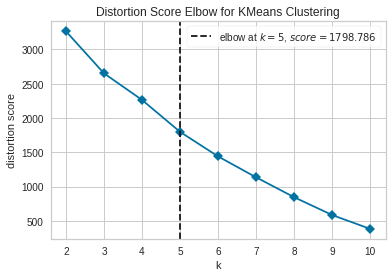

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Cluster
like,-0.184170,0.055115,-0.369530,-0.208950,0.256720,0.301420,0.162990,-0.164370,-0.070268,2.163800,...,0.194840,-0.133680,0.002850,-0.304140,0.285390,-0.331090,-0.238080,0.371320,0.361970,Cluster 1
nyx,0.346560,-0.252490,-0.073986,0.184100,0.142460,-0.299730,0.293220,-0.084776,0.012599,-1.176400,...,0.653510,0.060576,-0.699980,0.130320,-0.330550,-0.144280,0.061876,0.379920,0.026868,Cluster 2
dizziness,-0.331900,0.020677,-0.438340,0.127330,-0.233720,-0.249320,-0.213190,0.364670,0.030782,0.642480,...,0.110460,0.325740,-0.101010,0.010371,-0.020455,-0.011124,-0.204030,0.208060,0.164850,Cluster 4
suitable,0.285530,0.454930,-0.480820,-0.175670,0.325580,-0.038095,-0.036584,-0.026114,-0.186170,1.059300,...,-0.396350,-0.200980,-0.130490,0.037491,0.236150,0.196870,-0.578910,-0.307590,0.259690,Cluster 1
eye pencil,-0.119493,-0.403165,-0.309195,-0.044201,-0.270409,-0.475295,-0.068888,0.394225,-0.151502,1.139345,...,0.400270,0.283989,-0.323695,-0.039411,0.061550,0.337230,0.013510,0.258905,0.131749,Cluster 3
everyday life,-0.041580,0.302071,-0.046845,-0.086540,-0.116200,0.238416,-0.244560,0.143131,0.196075,2.509650,...,-0.170305,-0.025975,-0.102521,-0.009406,0.136092,0.196734,0.022370,-0.231095,-0.195742,Cluster 1
dark brown,-0.068575,-0.044478,0.067533,0.137155,0.017004,0.015530,-0.474735,0.186290,-0.134455,1.071365,...,0.259955,0.063442,-0.641615,-0.389345,0.620380,0.324370,-0.260580,-0.194280,0.069498,Cluster 1
hard,-0.284700,0.060205,-0.331980,-0.065790,0.040930,-0.253090,0.066547,-0.158760,0.386600,2.146900,...,-0.074317,-0.048285,-0.497210,-0.118980,0.207990,0.308680,0.011521,0.154380,-0.456820,Cluster 1
draw,-0.190950,-0.037522,-0.038896,0.252180,-0.167930,-0.442570,-0.006465,0.898310,-0.322620,2.006100,...,-0.009304,-0.209300,-0.150730,-0.107040,0.032931,0.268420,-0.274050,0.424830,-0.019467,Cluster 0
ordinary pen,-0.100874,-0.030025,-0.351495,0.041805,-0.315140,0.052120,0.021635,-0.035889,-0.047203,1.408705,...,0.066167,0.231370,0.019587,0.107400,-0.003750,0.353967,-0.178180,-0.182701,0.114715,Cluster 3


In [140]:
from pycaret.clustering import *
exp_clu101 = setup(df, normalize = True, session_id = 123)
kmeans = create_model('kmeans',num_clusters = 5)
plot_model(kmeans, plot = 'elbow')
kmean_results = assign_model(kmeans)
kmean_results

In [141]:
cluster_dict = {}
for i in kmean_results.index:
  cluster = kmean_results.loc[i]["Cluster"]
  if cluster not in cluster_dict:
    cluster_dict[cluster] = [i]
  else:
    cluster_dict[cluster].append(i)

for k, v in cluster_dict.items():
  print(k)
  print(v)

Cluster 1
['like', 'suitable', 'everyday life', 'dark brown', 'hard', 'kind', 'beautiful']
Cluster 2
['nyx']
Cluster 4
['dizziness']
Cluster 3
['eye pencil', 'ordinary pen', 'pen']
Cluster 0
['draw']


In [142]:
plot_model(kmeans)

# Sentiment Analysis

Following the categorisation step, we could parse the review that contain the explicit aspects then conduct sentiment analysis on the phrase with a pretrained model

# Issues so far with Rule-based/Unsupervised Methods

It is hard to clean the outputs and it is hard to extract the keypoint of the implicit aspects (e.g. beautiful --> look of product)
Using a pretrained model results in lower accuracy as the model is not adapted to the makeup domain
Analysing the phrase as a whole does not make the sentiment analysis aspect specific

In [132]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [146]:
for cluster, candidate_aspect_lst in cluster_dict.items():
  related_sentence_text = "\n".join(list(filter(lambda sent: any(aspect in sent.lower() for aspect in candidate_aspect_lst), opinion_sentence_lst)))
  print(cluster)
  print(candidate_aspect_lst)
  print(related_sentence_text)
  polarity = sentiment_pipeline(related_sentence_text)
  print(f"Polarity: {polarity}\n")

Cluster 1
['like', 'suitable', 'everyday life', 'dark brown', 'hard', 'kind', 'beautiful']
Let me first say that if your eyes are prone to dizziness, like inner double eyeliner, it may not be suitable for it
 but if you just have a very daily work makeup and you don t want to look abrupt, if you want to draw a very natural brown eyeliner, it is very suitable
It s dark brown: 903
It s super beautiful and looks good in everyday life
I also like it because it s an ordinary pen, so it s very hard
It s not the kind that breaks off when you draw it
Polarity: [{'label': 'POSITIVE', 'score': 0.9986103773117065}]

Cluster 2
['nyx']
 for NYX, The eye pencil is a very traditional eyeliner
Polarity: [{'label': 'POSITIVE', 'score': 0.9833393096923828}]

Cluster 4
['dizziness']
Let me first say that if your eyes are prone to dizziness, like inner double eyeliner, it may not be suitable for it
Polarity: [{'label': 'NEGATIVE', 'score': 0.9997455477714539}]

Cluster 3
['eye pencil', 'ordinary pen', 'pe

# Experiment: Supervised Learning

ABSA using pre-trained PyABSA (Supervised). There are several other online models but there are issues loading them.

The quality of the results vary but in this more challenging review where all the aspects are implicit, the model does not do well. It does better with explicit aspects.

In [ ]:
!pip install pyabsa==1.16.27

In [147]:
from pyabsa import ATEPCCheckpointManager

aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english')

No CUDA GPU found in your device
Version 1.16.27 of pyabsa is outdated. Version 2.2.0 was released 3 days ago.
PyABSA INFO: The PyABSA >= 2.0.0 version contains breaking changes, if you want to use the training and inference scripts (in demos directory), please do not upgrade to the >= 2.0.0 version
check release notes at https://github.com/yangheng95/PyABSA/blob/release/release-note.json
There may be some checkpoints available for early versions of PyABSA, see ATEPC
Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


577MB [00:06, 89.03MB/s, Downloading checkpoint...]                         

Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip, unzipping...


Done.
If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA-ATEPC/resolve/main/checkpoint/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip 
Load aspect extractor from ./checkpoints/ATEPC_ENGLISH_CHECKPOINT
config: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.config
state_dict: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.state_dict
model: None
tokenizer: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.tokenizer


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [148]:
# You can inference from a list of setences or a DatasetItem from PyABSA 
examples = opinion_sentence_lst
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,pred_sentiment=True)

The results of aspect term extraction have been saved in /content/drive/MyDrive/NUS/Y3S2/CS4242/ABSA/Aspects/atepc_inference.result.json
Example 0: Let me first say that if your eyes are prone to dizziness , like inner double eyeliner , it may not be suitable for it
Example 1: but if you just have a very daily work <makeup:Neutral Confidence:0.9963132739067078> and you don t want to look abrupt , if you want to draw a very natural brown eyeliner , it is very suitable
Example 2: for NYX , The eye pencil is a very traditional eyeliner
Example 3: It s dark <brown:Negative Confidence:0.6555421948432922> : 903
Example 4: It s super beautiful and <looks:Positive Confidence:0.9998313188552856> good in everyday life
Example 5: I also like it because it s an ordinary <pen:Positive Confidence:0.9990274906158447> , so it s very hard
Example 6: It s not the <kind:Negative Confidence:0.9939257502555847> that breaks off when you draw it


In [149]:
for i in range(len(examples)):
  print(examples[i])
  if atepc_result[i]["aspect"] != []:
    print(atepc_result[i]["aspect"])
    print(atepc_result[i]["sentiment"])
    print(atepc_result[i]["confidence"])
  else:
    print("No aspect identified")
  print("\n")

Let me first say that if your eyes are prone to dizziness, like inner double eyeliner, it may not be suitable for it
No aspect identified


 but if you just have a very daily work makeup and you don t want to look abrupt, if you want to draw a very natural brown eyeliner, it is very suitable
['makeup']
['Neutral']
[0.9963132739067078]


 for NYX, The eye pencil is a very traditional eyeliner
['eyeliner']
['Neutral']
[0.6889065504074097]


It s dark brown: 903
['brown']
['Negative']
[0.6555421948432922]


It s super beautiful and looks good in everyday life
['looks']
['Positive']
[0.9998313188552856]


I also like it because it s an ordinary pen, so it s very hard
['pen']
['Positive']
[0.9990274906158447]


It s not the kind that breaks off when you draw it
['kind']
['Negative']
[0.9939257502555847]




BEST OUTPUT: Using ChatGPT for ABSA

Rule-based and unsupervised methods struggled at the level of explicit aspect extraction. Pre-trained ABSA models are able to identify explicit aspects better but still miss out non-noun phrase based aspects. However, GPT-3 is able to conduct both implicit/explicit aspect extraction along with accurate sentiment analysis based on 2 chain prompts after experimentation.

In [150]:
!pip install openai==0.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 3.1 MB/s eta 0:00:00


In [151]:
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.8 MB/s eta 0:00:00


In [152]:
import tiktoken

def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301"):
  """Returns the number of tokens used by a list of messages."""
  try:
      encoding = tiktoken.encoding_for_model(model)
  except KeyError:
      encoding = tiktoken.get_encoding("cl100k_base")
  if model == "gpt-3.5-turbo-0301":  # note: future models may deviate from this
      num_tokens = 0
      for message in messages:
          num_tokens += 4  # every message follows <im_start>{role/name}\n{content}<im_end>\n
          for key, value in message.items():
              num_tokens += len(encoding.encode(value))
              if key == "name":  # if there's a name, the role is omitted
                  num_tokens += -1  # role is always required and always 1 token
      num_tokens += 2  # every reply is primed with <im_start>assistant
      return num_tokens
  else:
      raise NotImplementedError(f"""num_tokens_from_messages() is not presently implemented for model {model}.
  See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens.""")

In [154]:
#Reduce tokens to poll to reduce the costs by using only sentences with opinions
opinions = " ".join(opinion_sentence_lst)
print(len(opinions))
print(len(sample_review))

513
754


In [156]:
prompt = "Extract product names from the following text: " + opinions
second_prompt = "For each product in the text, extract Aspect Opinion pairs then assign them a positive or negative sentiment.Your response should be in JSON.An example output for one aspect opinion pair is {'Sephora Lipstick': {'Aspect':'Shade', 'Opinion':'Positive', 'Explanation':'Amazing shades'}. Do not include this example."

custom_msg = [
          {"role": "system", "content": "You are a helpful assistant that gets aspect opinion pairs."},
          {"role": "user", "content": prompt},
          {"role": "user", "content": second_prompt}
      ]
print(num_tokens_from_messages(custom_msg))

225


In [157]:
import openai

# Set up the OpenAI API client
openai.api_key = ""

try:
  # Generate a response

  response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=custom_msg
  )
except Exception as e:
    print("Error asking ChatGPT", e)

In [158]:
print(response['choices'][0]["message"]["content"])

{
"NYX Eye Pencil": [
    {"Aspect": "Suitability for sensitive eyes", "Opinion": "Negative", "Explanation": "may not be suitable for those with sensitive eyes or prone to dizziness"},
    {"Aspect": "Color", "Opinion": "Positive", "Explanation": "very natural brown"},
    {"Aspect": "Texture", "Opinion": "Positive", "Explanation": "very hard; not the kind that easily breaks off when you draw it"}, 
    {"Aspect": "Daily wear", "Opinion": "Positive", "Explanation": "super beautiful and looks good in everyday life"}           
]
}


In [159]:
import json
def get_json_obj_from_chatgpt_response(response,review_id):
  response_str = response['choices'][0]["message"]["content"]
  jsonResponse = json.loads(response_str)
  absa_dict_with_review_id = {review_id:jsonResponse}
  return absa_dict_with_review_id

review_id = "rqMqObrgFsc"

absa_dict = get_json_obj_from_chatgpt_response(response, review_id)
absa_dict

{'rqMqObrgFsc': {'NYX Eye Pencil': [{'Aspect': 'Suitability for sensitive eyes',
    'Opinion': 'Negative',
    'Explanation': 'may not be suitable for those with sensitive eyes or prone to dizziness'},
   {'Aspect': 'Color',
    'Opinion': 'Positive',
    'Explanation': 'very natural brown'},
   {'Aspect': 'Texture',
    'Opinion': 'Positive',
    'Explanation': 'very hard; not the kind that easily breaks off when you draw it'},
   {'Aspect': 'Daily wear',
    'Opinion': 'Positive',
    'Explanation': 'super beautiful and looks good in everyday life'}]}}